# Проект: классификация

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bank/bank_fin.csv', sep = ';')

In [ ]:
# Проверка количества пропущенных значений по каждому столбцу
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,25
housing,0
loan,0
contact,0
day,0


In [ ]:
# Вывод количества и доли пропущенных значений по каждому признаку
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

# Объединённая таблица
missing_table = pd.DataFrame({
    'Пропущено': missing,
    'Процент (%)': missing_percent
})

# Фильтруем только признаки с пропусками
missing_table = missing_table[missing_table['Пропущено'] > 0]
missing_table

,Пропущено,Процент (%)
balance,25,0.223974


### Задание 2

In [ ]:
# Уникальные значения в признаке job
print(df['job'].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']


In [ ]:
# Сколько строк с job == 'unknown'
df[df['job'] == 'unknown'].shape[0]

70

### Задание 3

In [ ]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,float64
housing,object
loan,object
contact,object
day,int64


In [ ]:
# Преобразуем balance в строку, убираем лишнее и меняем запятые на точки (если есть)
df['balance'] = df['balance'].astype(str).str.replace(',', '.').str.replace(' ', '')

# Преобразуем в float
df['balance'] = pd.to_numeric(df['balance'], errors='coerce')

In [ ]:
df['balance'].dtype

dtype('float64')

### Задание 4

In [ ]:
# Заново читаем файл
df = pd.read_csv('/content/drive/MyDrive/Bank/bank_fin.csv', sep=';')

# Смотрим первую сырую строку
print("Сырая строка balance:", repr(df['balance'].iloc[0]))

# Очищаем balance:
# 1. Удалим всё, кроме цифр, запятых, точек, минусов
# 2. Заменим запятую на точку
df['balance'] = df['balance'].astype(str)
df['balance'] = df['balance'].str.replace(r'[^\d,.-]', '', regex=True)
df['balance'] = df['balance'].str.replace(',', '.', regex=False)

# Преобразуем в float
df['balance'] = pd.to_numeric(df['balance'], errors='coerce')

# Проверим результат
print("После преобразования:")
print(df['balance'].head(10))
print("Пропущенных значений:", df['balance'].isnull().sum())

Сырая строка balance: ' 2 343,00 $ '
После преобразования:
0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
5       0.0
6     830.0
7     545.0
8       1.0
9       NaN
Name: balance, dtype: float64
Пропущенных значений: 25


In [ ]:
# Заполняем пропущенные значения медианой
df['balance'] = df['balance'].fillna(df['balance'].median())

# Проверяем результат
print("✅ Пропущенных значений после заполнения:", df['balance'].isnull().sum())

✅ Пропущенных значений после заполнения: 0


### Задание 5

In [ ]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
print("job — 'unknown':", df['job'].value_counts().get('unknown', 0))
print("education — 'unknown':", df['education'].value_counts().get('unknown', 0))

job — 'unknown': 70
education — 'unknown': 497


In [ ]:
job_mode = df['job'].mode()[0]
edu_mode = df['education'].mode()[0]
print("Мода для job:", job_mode)
print("Мода для education:", edu_mode)

Мода для job: management
Мода для education: secondary


In [ ]:
df['job'] = df['job'].replace('unknown', job_mode)
df['education'] = df['education'].replace('unknown', edu_mode)

In [ ]:
print("job — 'unknown':", df['job'].value_counts().get('unknown', 0))
print("education — 'unknown':", df['education'].value_counts().get('unknown', 0))

job — 'unknown': 0
education — 'unknown': 0


### Задание 6

In [ ]:
# Вычисляем границы по IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем только нормальные значения
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# Проверка
print("✅ Баланс после удаления выбросов:")
print("Минимум:", df['balance'].min())
print("Максимум:", df['balance'].max())
print("Размер датафрейма:", df.shape)

✅ Баланс после удаления выбросов:
Минимум: -2049.0
Максимум: 4063.0
Размер датафрейма: (10105, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

Соотношение классов:
deposit
no     5424
yes    4681
Name: count, dtype: int64


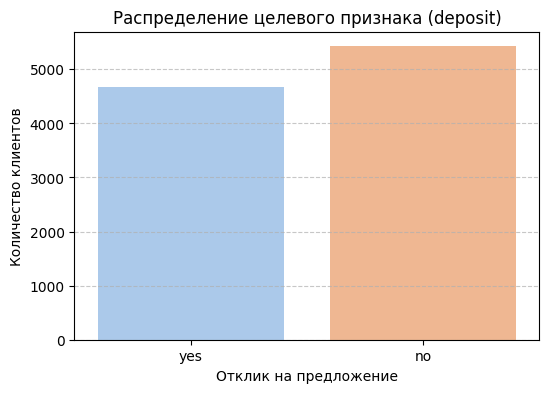

In [ ]:
# Подсчёт значений
class_counts = df['deposit'].value_counts()
print("Соотношение классов:")
print(class_counts)

# Визуализация — barplot
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='deposit', palette='pastel')
plt.title('Распределение целевого признака (deposit)')
plt.xlabel('Отклик на предложение')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Задания 2 и 3

In [ ]:
# Смотрим числовые признаки
df.select_dtypes(include=['int64', 'float64']).columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [ ]:
# Статистики по количественным переменным
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [ ]:
# Более читабельный вариант, округление
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.90,11.73,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.65,994.15,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.59,8.44,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.74,346.65,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.52,2.71,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.32,109.64,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.82,2.24,0.0,0.0,0.0,1.0,58.0


### Описательные статистики количественных признаков

#### 1. `age`
- Средний возраст клиента: **40.9 лет**
- Диапазон: от **18** до **95 лет**
- Медиана (38) < среднее — распределение слегка скошено вправо (в сторону пожилых)
- Большинство клиентов — в возрасте от **32 до 48 лет**

#### 2. `balance`
- Средний баланс: **807.7**
- Диапазон: от **–2049** до **4063** (ранее уже обработали выбросы)
- Высокое стандартное отклонение (994.2) говорит о сильной разности в доходах
- Медиана (**445**) меньше среднего — есть некоторое количество клиентов с крупными счетами

#### 3. `day` (день месяца, когда был контакт)
- Среднее: **15.6**, диапазон: **1–31**
- Это не полезный предиктор сам по себе, но может быть связан с результативностью в начале или в конце месяца

#### 4. `duration` (длительность последнего контакта)
- Средняя длительность: **368.7 секунд (~6 минут)**
- Диапазон: от **2** до **3881 секунд (~1 час!)**
- ВАЖНО: этот признак **не может использоваться при обучении модели**, так как он известен **только после контакта**
- Тем не менее, он может быть полезен при анализе поведения клиентов

#### 5. `campaign` (кол-во контактов в текущей кампании)
- Среднее: **2.52**, медиана: **2**, максимум: **43**
- Большинство клиентов получали **1–3 контакта**
- Значение `43` — возможный выброс или очень настойчивый маркетинг 😅

#### 6. `pdays` (кол-во дней с момента последнего контакта)
- Значение **-1** означает "никогда не контактировали"
- Большинство клиентов (по медиане и 25/75 перцентилям) имеют `-1`, значит **новые клиенты**
- Максимум: **854 дня (~2.3 года)**

#### 7. `previous` (число предыдущих контактов до текущей кампании)
- Медиана: **0**, 75% клиентов — максимум 1 контакт
- Максимум: **58 контактов** — очень редкие случаи
- Значение сильно скошено — много нулей

### Общие выводы:
- Признаки `balance`, `duration`, `pdays`, `previous` имеют скошенные распределения и возможные выбросы
- `duration` **не следует включать в модель**, чтобы избежать утечки данных
- Некоторые признаки могут потребовать нормализации или лог-преобразования при использовании в модели

### Задания 4 и 5

In [ ]:
# Категориальные переменные
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'deposit'],
      dtype='object')

In [ ]:
# Показываем распределение по каждой категории
for col in cat_cols:
    print(f"Распределение: {col}")
    print(df[col].value_counts(normalize=True).round(3) * 100)
    print('\n')

Распределение: job
job
management       22.9
blue-collar      17.9
technician       16.2
admin.           12.3
services          8.6
retired           6.6
self-employed     3.5
unemployed        3.3
student           3.2
entrepreneur      3.0
housemaid         2.5
Name: proportion, dtype: float64


Распределение: marital
marital
married     56.6
single      31.8
divorced    11.6
Name: proportion, dtype: float64


Распределение: education
education
secondary    54.6
tertiary     32.1
primary      13.3
Name: proportion, dtype: float64


Распределение: default
default
no     98.4
yes     1.6
Name: proportion, dtype: float64


Распределение: housing
housing
no     51.9
yes    48.1
Name: proportion, dtype: float64


Распределение: loan
loan
no     86.2
yes    13.8
Name: proportion, dtype: float64


Распределение: contact
contact
cellular     72.1
unknown      21.4
telephone     6.5
Name: proportion, dtype: float64


Распределение: month
month
may    25.9
jul    14.0
aug    13.7
jun    10.9


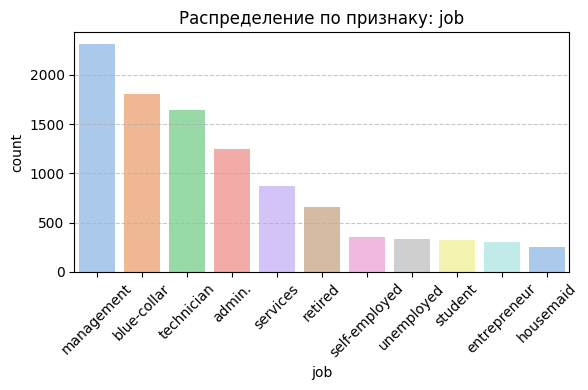

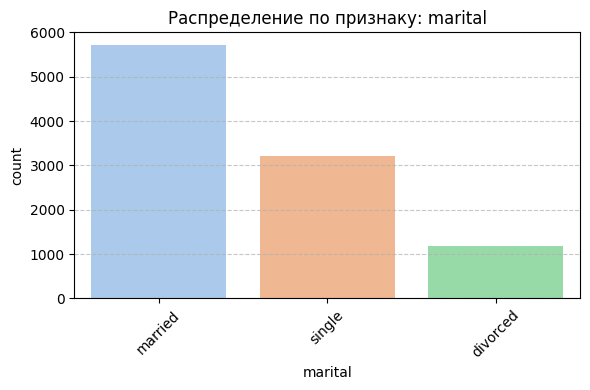

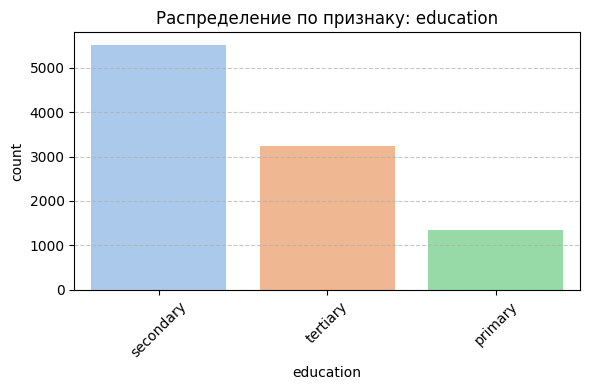

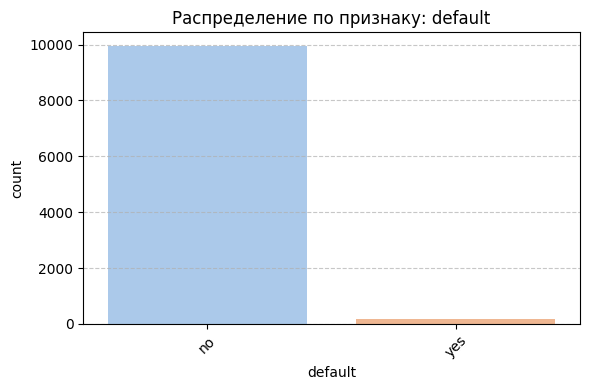

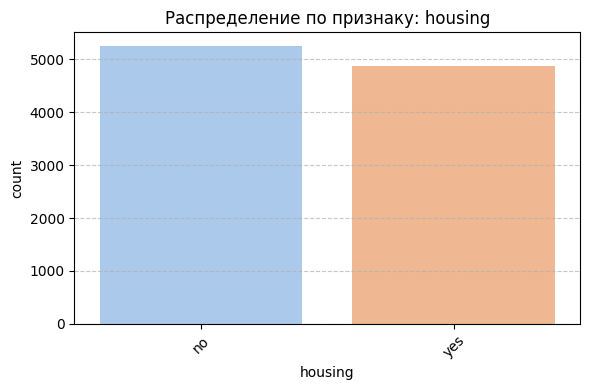

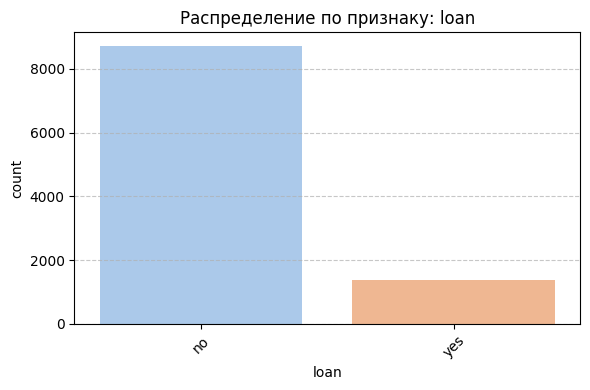

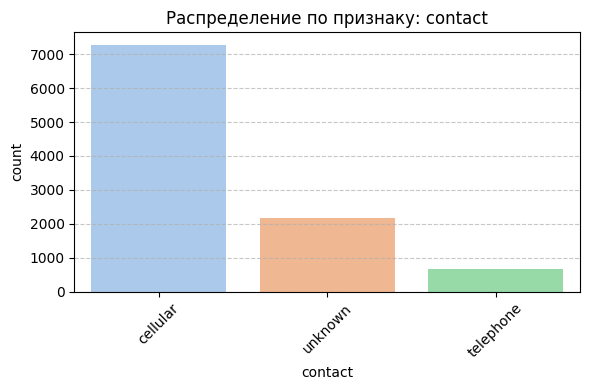

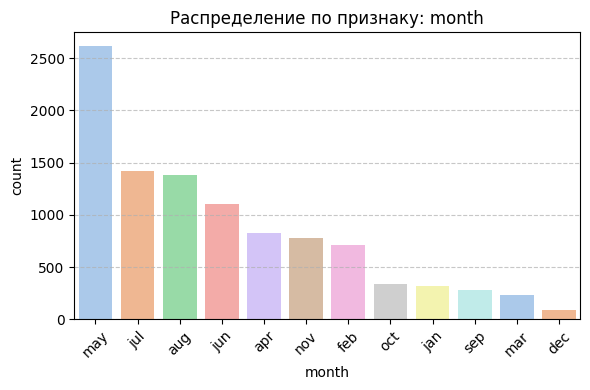

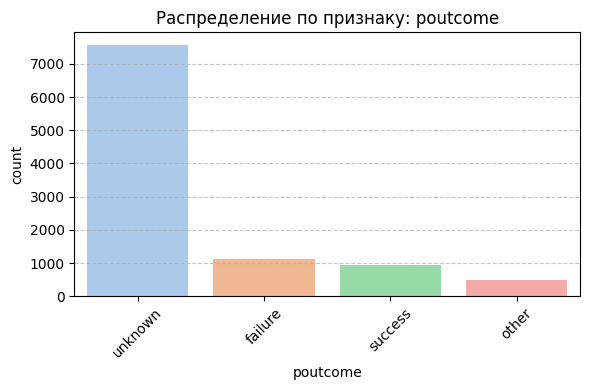

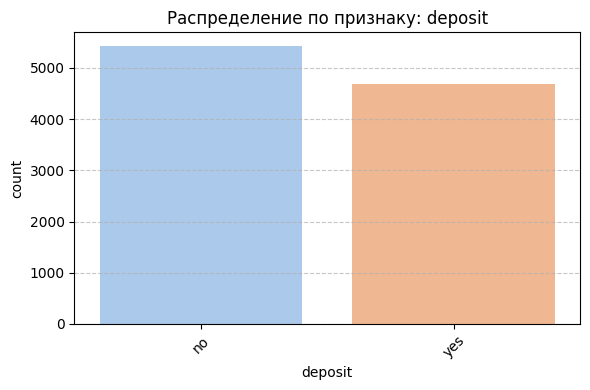

In [ ]:
# Автоматически строим графики
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='pastel')
    plt.title(f'Распределение по признаку: {col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

📊 Интерпретация графика contact

На диаграмме показано, как часто использовались разные каналы связи при обращении к клиентам в маркетинговой кампании:
🔹 cellular (мобильный телефон) — самый популярный канал

    Им пользовались в подавляющем большинстве случаев (~72% клиентов).

    Это логично: мобильные телефоны всегда под рукой, клиент чаще ответит и дослушает звонок.

    Вероятно, именно через мобильную связь банк добивался наилучших результатов.

🔸 unknown (неизвестный тип контакта) — вторая по частоте категория

    Примерно у 21% клиентов канал связи не указан.

    Это может быть автоматический звонок, SMS, не зафиксированный контакт или отсутствие данных.

    Такие значения стоит обрабатывать как отдельную категорию или, при необходимости, исключить.

🟢 telephone (стационарный телефон) — наименее используемый канал

    Использовался только у 6.5% клиентов.

    Это может быть связано с устареванием стационарной связи и низкой эффективностью такого способа коммуникации.

  📌 Вывод:

    📱 Банк делает ставку на мобильную связь — это правильно и отражает реальную коммуникационную среду.

    ⚠️ Значения unknown требуют внимательного подхода: либо сохранить как категорию, либо исследовать поведение таких клиентов отдельно.

    ☎️ Контакты по стационарному телефону используются редко и могут быть малозначимыми в модели.

### Задание 6

In [ ]:
# Кросс-таблица по poutcome и целевому признаку deposit
poutcome_table = pd.crosstab(df['poutcome'], df['deposit'])
print(poutcome_table)

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


In [ ]:
# Выделим строки, где количество 'yes' больше 'no'
more_success = poutcome_table[poutcome_table['yes'] > poutcome_table['no']]
more_success

deposit,no,yes
poutcome,,
other,216,265
success,84,861


Успехи (deposit = yes) превалируют над отказами (no) в следующих категориях poutcome:

    success — особенно сильно: 861 против 84

    other — умеренно: 265 против 216

### Задание 6. Результат предыдущей кампании (`poutcome`) и отклик в текущей

Проведён анализ связи между результатом предыдущей маркетинговой кампании (`poutcome`)  
и откликом клиента на текущее предложение (`deposit`).

Результаты:

- `success`: 861 отклик против 84 отказов — **ярко выраженная положительная связь**
- `other`: 265 откликов против 216 отказов — **умеренное преобладание успеха**

Таким образом, если клиент участвовал в прошлой кампании с положительным результатом (`success`),  
он **с высокой вероятностью** откликнется и в этот раз. Это ценный сигнал для таргетинга.

Категория `unknown` (не участвовал ранее) — самая массовая, но у неё преобладают отказы.

### Задание 7

In [ ]:
# Кросс-таблица количества откликов по месяцам
month_table = pd.crosstab(df['month'], df['deposit'])
print(month_table)

deposit    no  yes
month             
apr       317  513
aug       775  610
dec         9   84
feb       323  386
jan       194  125
jul       836  582
jun       606  498
mar        24  213
may      1776  841
nov       456  324
oct        62  273
sep        46  232


In [ ]:
# Месяц с максимальным количеством отказов (no)
month_with_most_nos = month_table['no'].idxmax()
num_nos = month_table['no'].max()

print(f"🔎 Больше всего отказов было в месяце: {month_with_most_nos} ({num_nos} отказов)")

🔎 Больше всего отказов было в месяце: may (1776 отказов)


📌 Ответ на задание 7:

    🔴 Месяц с наибольшим числом отказов: may

    📊 Количество отказов: 1776

    При этом количество согласий в мае — 841 (значительно меньше отказов)

### Задание 8

In [ ]:
# Создаём возрастные группы
bins = [18, 30, 40, 50, 60, 100]
labels = ['18–30', '31–40', '41–50', '51–60', '61+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Проверка
df[['age', 'age_group']].head()

,age,age_group
0,59,51–60
1,56,51–60
2,41,41–50
3,55,51–60
4,54,51–60


In [ ]:
# Кросс-таблица: возрастные группы и отклик
age_deposit = pd.crosstab(df['age_group'], df['deposit'])
print(age_deposit)

deposit      no   yes
age_group            
18–30       818  1044
31–40      2215  1627
41–50      1360   895
51–60       933   692
61+          97   416


In [ ]:
# Группы, где откликов больше, чем отказов
more_yes_groups = age_deposit[age_deposit['yes'] > age_deposit['no']]
print("Группы, более склонные открывать депозит:")
print(more_yes_groups)

Группы, более склонные открывать депозит:
deposit     no   yes
age_group           
18–30      818  1044
61+         97   416


### Задание 8. Возрастные группы и склонность к открытию депозита

Клиенты были разбиты на 5 возрастных категорий:
- `18–30`
- `31–40`
- `41–50`
- `51–60`
- `61+`

Анализ показал, что **в двух группах**:
- `18–30`
- `61+`

количество откликов **`yes` превышает `no`**, то есть эти клиенты **более склонны открывать депозит**.

Это ценный инсайт:
- Молодые клиенты (18–30) более открыты к предложениям
- Пожилые клиенты (61+) чаще заинтересованы в сбережениях

📌 Такие группы можно рассматривать как **целевую аудиторию** при планировании будущих кампаний.

### Задания 9 и 10

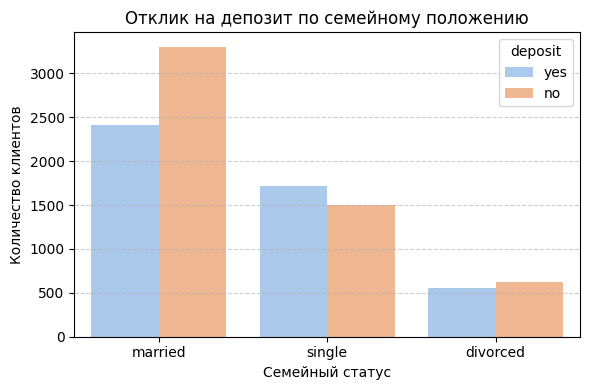

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='marital', hue='deposit', palette='pastel')
plt.title('Отклик на депозит по семейному положению')
plt.xlabel('Семейный статус')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

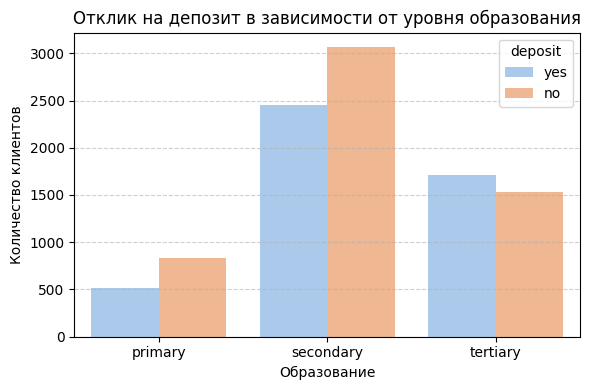

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='education', hue='deposit', palette='pastel', order=['primary', 'secondary', 'tertiary'])
plt.title('Отклик на депозит в зависимости от уровня образования')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

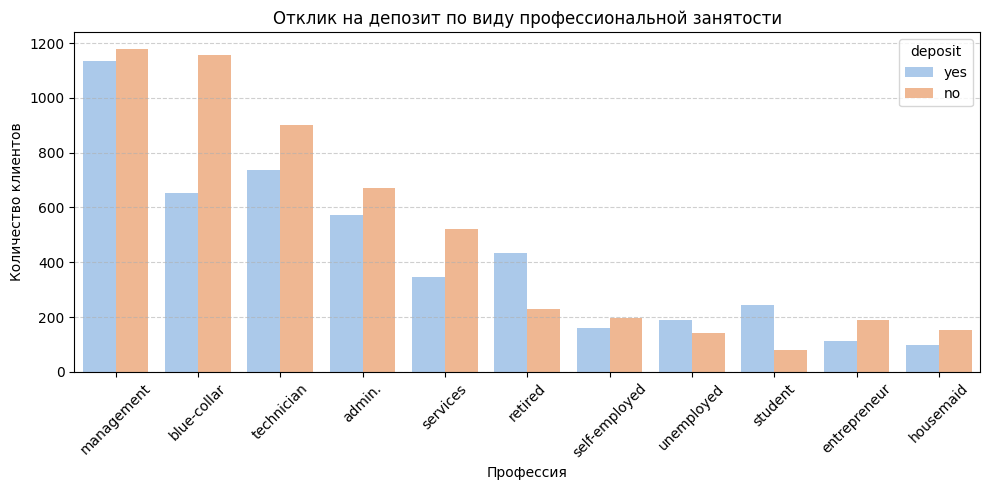

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='job', hue='deposit', palette='pastel', order=df['job'].value_counts().index)
plt.title('Отклик на депозит по виду профессиональной занятости')
plt.xlabel('Профессия')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Задание 11

In [ ]:
# Отбираем только клиентов, открывших депозит
df_yes = df[df['deposit'] == 'yes']

In [ ]:
# Сводная таблица по образованию и семейному положению
pivot_table = pd.pivot_table(
    df_yes,
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count',
    fill_value=0
)

print(pivot_table)

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


In [ ]:
# Найдём комбинацию с максимальным числом откликов
max_value = pivot_table.values.max()
max_group = pivot_table.stack().idxmax()

print(f"🔎 Наиболее многочисленная группа среди откликнувшихся:")
print(f"Образование: {max_group[0]}, Семейный статус: {max_group[1]} ({max_value} человек)")

🔎 Наиболее многочисленная группа среди откликнувшихся:
Образование: secondary, Семейный статус: married (1289 человек)


### Задание 11. Наиболее многочисленная группа откликнувшихся по образованию и семейному положению

На основе сводной таблицы, построенной по признакам `education` и `marital`,  
определено, какие категории наиболее часто открывали депозит (`deposit = yes`).

🔍 **Наиболее многочисленная группа:**
- **Образование:** `secondary`
- **Семейный статус:** `married`
- **Количество клиентов:** 1289

📌 Это самая представительная подгруппа среди тех, кто откликнулся.  
Рекомендуется рассматривать клиентов с таким профилем как ключевую часть целевой аудитории при будущих кампаниях.

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# Словарь для преобразования
edu_map = {
    'primary': 0,
    'secondary': 1,
    'tertiary': 2
}

# Преобразуем
df['education_level'] = df['education'].map(edu_map)

# Проверим результат
df[['education', 'education_level']].drop_duplicates()

,education,education_level
0,secondary,1
4,tertiary,2
16,primary,0


### Часть 3 — Задание 1: Преобразование уровней образования

Категориальный признак `education` был преобразован в числовой вид:

- `primary` → 0  
- `secondary` → 1  
- `tertiary` → 2

Создан новый столбец `education_level`, который будет использоваться при обучении модели.  
Это упрощает работу алгоритмов машинного обучения, особенно если модель не поддерживает категориальные переменные напрямую.

### Задания 2 и 3

In [ ]:
# Список бинарных признаков
binary_cols = ['default', 'housing', 'loan', 'deposit']

# Преобразование значений
df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'yes' else 0)

# Проверим результат
df[binary_cols].head()

,default,housing,loan,deposit
0,0,1,0,1
1,0,0,0,1
2,0,1,0,1
3,0,1,0,1
4,0,0,0,1


### Задания 2 и 3. Преобразование бинарных признаков

Преобразованы следующие бинарные переменные:

- `default` — наличие просроченного кредита
- `housing` — наличие ипотечного кредита
- `loan` — наличие потребительского кредита
- `deposit` — целевая переменная (открыл депозит или нет)

Значения `yes` были заменены на `1`, а `no` — на `0`.

Это преобразование необходимо для корректной работы моделей машинного обучения,  
так как многие алгоритмы требуют числового представления признаков.

### Задание 4

In [ ]:
# Категориальные признаки для one-hot encoding
cat_features = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаём дамми-переменные
df_dummies = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Проверим размер и первые столбцы
print("Размер датафрейма после кодирования:", df_dummies.shape)
df_dummies.head()

Размер датафрейма после кодирования: (10105, 42)


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,secondary,0,2343.0,1,0,5,1042,1,-1,...,False,False,False,True,False,False,False,False,False,True
1,56,secondary,0,45.0,0,0,5,1467,1,-1,...,False,False,False,True,False,False,False,False,False,True
2,41,secondary,0,1270.0,1,0,5,1389,1,-1,...,False,False,False,True,False,False,False,False,False,True
3,55,secondary,0,2476.0,1,0,5,579,1,-1,...,False,False,False,True,False,False,False,False,False,True
4,54,tertiary,0,184.0,0,0,5,673,2,-1,...,False,False,False,True,False,False,False,False,False,True


In [ ]:
# Выводим новые столбцы
new_columns = [col for col in df_dummies.columns if any(feat in col for feat in cat_features)]
print("Созданы дамми-признаки:")
print(new_columns)

Созданы дамми-признаки:
['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


### Задание 4. Создание дамми-переменных (one-hot encoding)

Для следующих категориальных признаков были созданы дамми-переменные:

- `job` (10 категорий)
- `marital` (2 категории: `married`, `single`; `divorced` отброшен по `drop_first=True`)
- `contact`
- `month` (11 месяцев из 12, без дублирования)
- `poutcome`

Итог:
- Размер датафрейма увеличился до **42 признаков**
- Все дамми-переменные представлены в виде булевых значений (`True` / `False`), при необходимости их можно привести к числовому виду
- Использован параметр `drop_first=True` для предотвращения мультиколлинеарности

Пример созданных признаков:
- `job_blue-collar`, `job_technician`, ...
- `marital_single`, `marital_married`
- `month_may`, `month_jul`, ...
- `poutcome_success`, `poutcome_unknown`

Теперь данные полностью готовы для подачи в модель машинного обучения.

### Задания 5 и 6

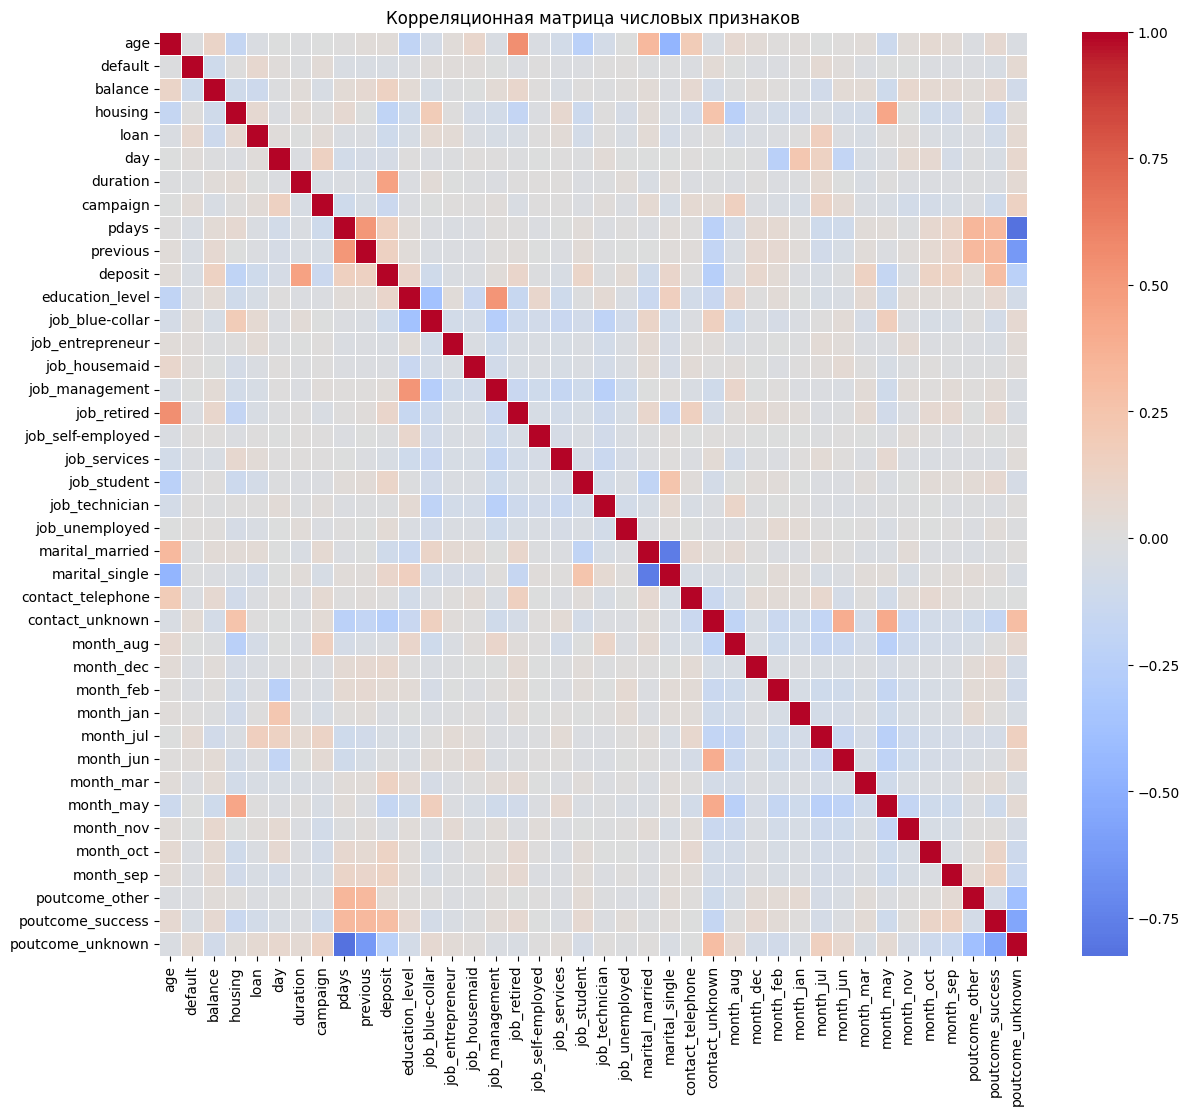

In [ ]:
# Удалим нечисловые признаки, если остались
df_numeric = df_dummies.select_dtypes(include=['int64', 'float64', 'bool'])  # bool на всякий случай

# Строим корреляционную матрицу только по числовым признакам
plt.figure(figsize=(14, 12))
corr_matrix = df_numeric.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

In [ ]:
# Находим пары признаков с сильной корреляцией (без дубликатов и самого себя)
def find_strong_correlations(corr_matrix, threshold=0.7):
    corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
    strong_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > threshold)]
    return strong_pairs

strong_corrs = find_strong_correlations(corr_matrix)
print("🔎 Сильно коррелирующие признаки (|corr| > 0.7):")
print(strong_corrs)

🔎 Сильно коррелирующие признаки (|corr| > 0.7):
poutcome_unknown  pdays               0.824031
pdays             poutcome_unknown    0.824031
marital_married   marital_single      0.779038
marital_single    marital_married     0.779038
dtype: float64


### Задания 5 и 6. Корреляционная матрица и оценка мультиколлинеарности

Была построена корреляционная матрица всех числовых признаков.

#### 🔍 Наиболее сильные корреляции:

- `poutcome_unknown` ↔ `pdays`: **0.82**
- `marital_married` ↔ `marital_single`: **0.78**

Такие высокие значения могут привести к мультиколлинеарности, особенно при использовании линейных моделей  
(например, логистической регрессии). Это можно решить следующими способами:
- Удалить один из сильно коррелирующих признаков
- Использовать регуляризацию (например, L2 — Ridge)
- Применять модели, устойчивые к мультиколлинеарности (например, деревья решений, ансамбли)

В остальном признаки коррелируют слабо и не вызывают опасений.

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# Пересоздаём дамми-переменные с добавлением education
cat_features = ['job', 'marital', 'contact', 'month', 'poutcome', 'education']

df_dummies = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Теперь всё готово для обучения
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.33
)

In [ ]:
# Удаляем колонку age_group, если она есть
if 'age_group' in df_dummies.columns:
    df_dummies = df_dummies.drop(['age_group'], axis=1)

# Обновляем X и y
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']

# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.33
)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

📊 Метрики качества логистической регрессии:
Accuracy: 0.818
Precision: 0.817
Recall: 0.782
F1 Score: 0.799
ROC AUC Score: 0.898


<Figure size 500x400 with 0 Axes>

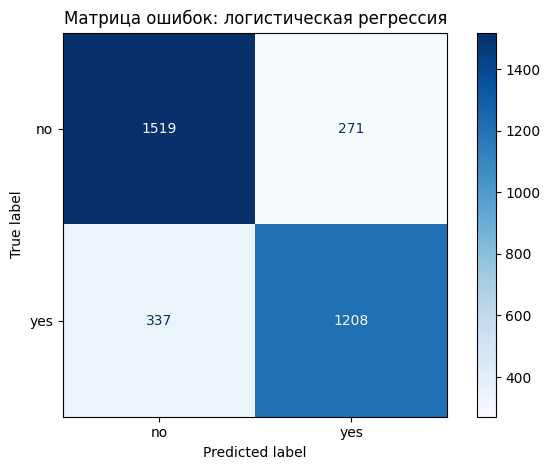

In [ ]:
# 📊 Расчёт метрик
print("📊 Метрики качества логистической регрессии:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1 Score:", round(f1_score(y_test, y_pred), 3))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 3))

# 🔲 Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Матрица ошибок: логистическая регрессия")
plt.grid(False)
plt.tight_layout()
plt.show()

### Часть 4 — Задания 7 и 8: Логистическая регрессия и оценка качества модели

Обучена логистическая регрессия на признаках, преобразованных в числовой вид.

#### 📊 Метрики модели:
- **Accuracy**: 81.8%
- **Precision**: 81.7%
- **Recall**: 78.2%
- **F1-score**: 79.9%
- **ROC AUC**: 89.8%

Модель показывает хорошую сбалансированность между точностью и полнотой.  
Высокий ROC AUC (почти 90%) свидетельствует о хорошем разделении классов.

#### 🔲 Матрица ошибок:
- 1519 клиентов правильно определены как не заинтересованные
- 1208 клиентов — правильно как откликнувшиеся
- 271 — ложно предсказаны как "да", хотя они отказались
- 337 — упущены потенциально заинтересованные клиенты

### Задание 9

In [ ]:
# Применяем SelectKBest с f-критерием ANOVA (для классификации)
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

# Получим маску отобранных признаков
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]

print("🔝 15 лучших признаков:")
print(selected_features.tolist())

🔝 15 лучших признаков:
['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_student', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Инициализируем scaler
scaler = MinMaxScaler()

# Обучаем scaler на обучающих данных и трансформируем их
X_train_scaled = scaler.fit_transform(X_train)

# Применяем тот же scaler к тестовым данным
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Превращаем обратно в DataFrame (по желанию, для читаемости)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Проверим диапазон значений
print(X_train_scaled_df.describe().T[['min', 'max']].round(2))

                     min  max
age                  0.0  1.0
default              0.0  1.0
balance              0.0  1.0
housing              0.0  1.0
loan                 0.0  1.0
day                  0.0  1.0
duration             0.0  1.0
campaign             0.0  1.0
pdays                0.0  1.0
previous             0.0  1.0
education_level      0.0  1.0
job_blue-collar      0.0  1.0
job_entrepreneur     0.0  1.0
job_housemaid        0.0  1.0
job_management       0.0  1.0
job_retired          0.0  1.0
job_self-employed    0.0  1.0
job_services         0.0  1.0
job_student          0.0  1.0
job_technician       0.0  1.0
job_unemployed       0.0  1.0
marital_married      0.0  1.0
marital_single       0.0  1.0
contact_telephone    0.0  1.0
contact_unknown      0.0  1.0
month_aug            0.0  1.0
month_dec            0.0  1.0
month_feb            0.0  1.0
month_jan            0.0  1.0
month_jul            0.0  1.0
month_jun            0.0  1.0
month_mar            0.0  1.0
month_may 

### Задание 10. Нормализация данных с помощью MinMaxScaler

Все признаки были нормализованы с помощью `MinMaxScaler`, чтобы привести значения к диапазону [0, 1].

Это особенно важно для моделей, чувствительных к масштабу признаков (например, логистическая регрессия, KNN, SVM).  
Нормализация выполнена отдельно для обучающей и тестовой выборок с использованием одного и того же `scaler`.

✅ Результат:
- Минимальное значение: **0.0**
- Максимальное значение: **1.0**
- Все признаки нормализованы корректно

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Обучаем логистическую регрессию
model_lr = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr.fit(X_train_scaled, y_train)

# Предсказания
y_pred_lr = model_lr.predict(X_test_scaled)
y_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print("📊 Метрики логистической регрессии (на нормализованных данных):")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("Precision:", round(precision_score(y_test, y_pred_lr), 3))
print("Recall:", round(recall_score(y_test, y_pred_lr), 3))
print("F1 Score:", round(f1_score(y_test, y_pred_lr), 3))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba_lr), 3))

📊 Метрики логистической регрессии (на нормализованных данных):
Accuracy: 0.815
Precision: 0.82
Recall: 0.769
F1 Score: 0.794
ROC AUC Score: 0.896


<Figure size 500x400 with 0 Axes>

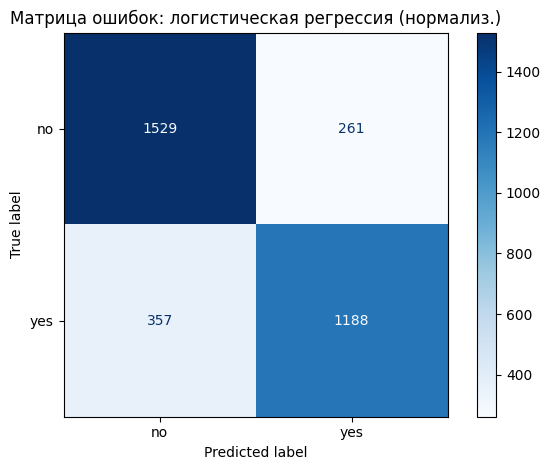

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Матрица ошибок: логистическая регрессия (нормализ.)")
plt.grid(False)
plt.tight_layout()
plt.show()

### Часть 4 — Задание 1. Логистическая регрессия (на нормализованных данных)

Обучена модель логистической регрессии на нормализованных признаках (`MinMaxScaler`).

#### 📊 Метрики:
- **Accuracy**: 81.5%
- **Precision**: 82.0%
- **Recall**: 76.9%
- **F1-score**: 79.4%
- **ROC AUC**: 89.6%

Матрица ошибок показала:
- 1529 верных отказов
- 1188 верных согласий
- 261 клиента ошибочно отнесены к откликнувшимся
- 357 потенциально заинтересованных клиентов не были обнаружены

Модель демонстрирует хорошее качество и может использоваться как baseline. Следующим шагом будет обучение дерева решений.

### Задания 2,3,4

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
results = []

for depth in range(1, 21):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    y_proba = tree.predict_proba(X_test)[:, 1]

    results.append({
        'depth': depth,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

# Превращаем в DataFrame для анализа
import pandas as pd
results_df = pd.DataFrame(results)
results_df.set_index('depth', inplace=True)
results_df.head(10)

,accuracy,precision,recall,f1,roc_auc
depth,,,,,
1,0.717241,0.747126,0.588997,0.658704,0.708465
2,0.766117,0.765810,0.713269,0.738606,0.781271
3,0.776912,0.801354,0.689320,0.741127,0.821545
4,0.780210,0.790000,0.715858,0.751104,0.853511
5,0.781109,0.714361,0.878964,0.788160,0.862735
6,0.805097,0.764012,0.838188,0.799383,0.868871
7,0.817691,0.784112,0.836893,0.809643,0.865391
8,0.821889,0.794427,0.830421,0.812025,0.868518
9,0.821289,0.793808,0.829773,0.811392,0.861872


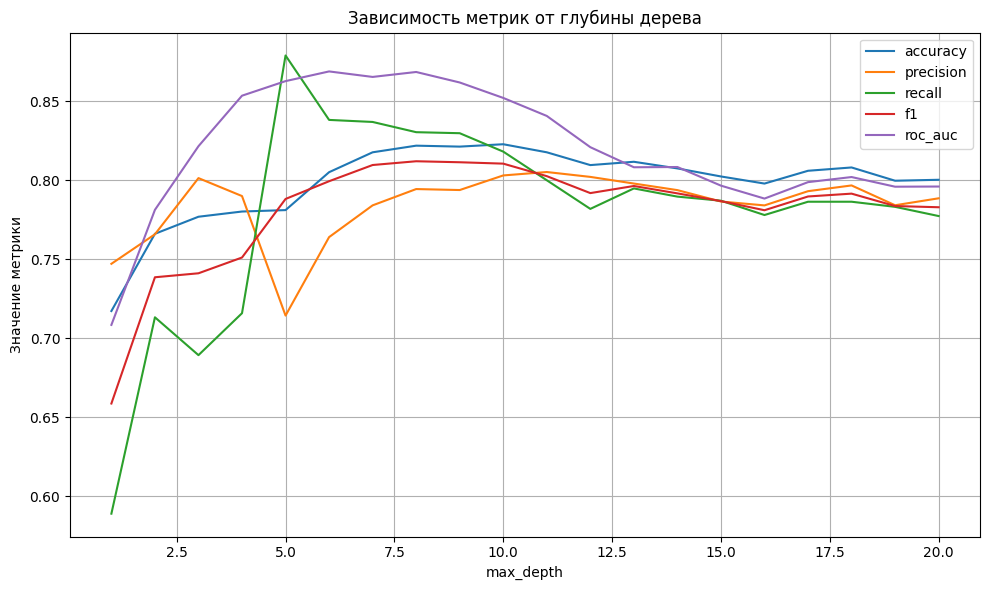

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    plt.plot(results_df.index, results_df[metric], label=metric)

plt.xlabel('max_depth')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от глубины дерева')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🎯 Лучшая глубина дерева по F1-score: 8


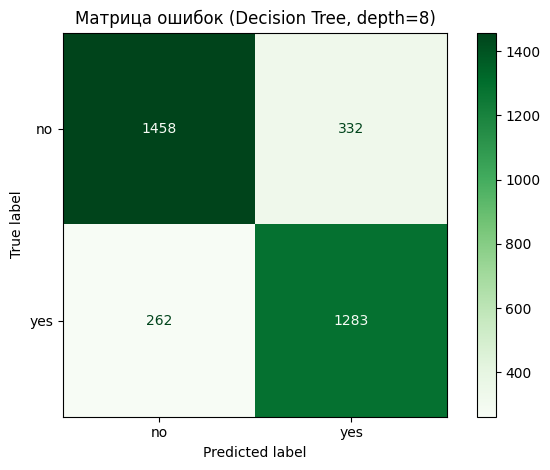

In [ ]:
best_depth = results_df['f1'].idxmax()
print(f"🎯 Лучшая глубина дерева по F1-score: {best_depth}")

best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(X_train, y_train)
y_pred_best = best_tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot(cmap='Greens', values_format='d')
plt.title(f"Матрица ошибок (Decision Tree, depth={best_depth})")
plt.grid(False)
plt.tight_layout()
plt.show()

### Задания 2–4. Обучение и настройка решающего дерева

Было обучено решающее дерево (`DecisionTreeClassifier`) с перебором глубины от 1 до 20.  
Оптимальная глубина по F1-score: **8**

#### 📈 Метрики при depth=8:
- Accuracy: 82.2%
- Precision: 79.4%
- Recall: 83.0%
- F1-score: 81.2%
- ROC AUC: 86.9%

#### 📊 Сравнение с логистической регрессией:
- Дерево лучше по F1 и Recall
- Логистическая регрессия — чуть выше ROC AUC

Решающие деревья более склонны к переобучению,  
но при правильной настройке дают хорошую интерпретируемость и качество.

### Задание 5

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Словарь параметров
param_grid = {
    'max_depth': range(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Модель
dt = DecisionTreeClassifier(random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Обучение модели
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 15),
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [ ]:
DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=5,
    random_state=42
)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=5, random_state=42)

### Задание 5. Подбор параметров с помощью GridSearchCV

С помощью `GridSearchCV` была выполнена настройка модели `DecisionTreeClassifier`.

🔍 Найденные оптимальные параметры:
- `max_depth`: **12**
- `min_samples_leaf`: **5**

Подбор проводился по метрике **F1-score**, с использованием кросс-валидации (`cv=5`).  
Модель с оптимальными параметрами будет использоваться в дальнейших экспериментах.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

# Обучаем Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
print("📊 Метрики случайного леса:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("F1-score:", round(f1_score(y_test, y_pred_rf), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_rf), 3))

print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["no", "yes"]))

📊 Метрики случайного леса:
Accuracy: 0.847
F1-score: 0.84
ROC AUC: 0.914

🔍 Classification Report:
              precision    recall  f1-score   support

          no       0.88      0.83      0.85      1790
         yes       0.82      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



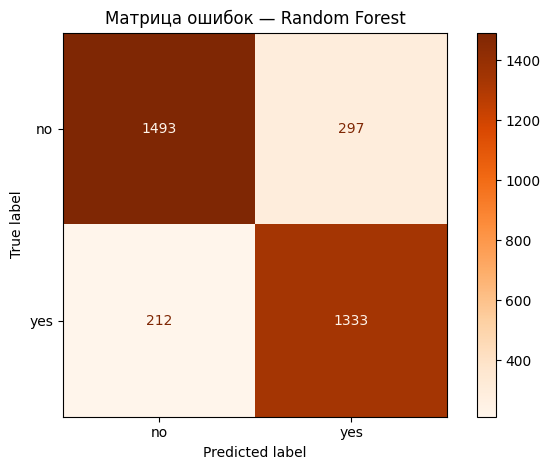

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot(cmap='Oranges', values_format='d')
plt.title("Матрица ошибок — Random Forest")
plt.grid(False)
plt.tight_layout()
plt.show()

### Часть 5 — Задание 1. Обучение модели случайного леса

Обучена модель `RandomForestClassifier` с 100 деревьями на полной обучающей выборке.

#### 📊 Метрики на тестовой выборке:
- Accuracy: 84.7%
- F1-score: 84.0%
- ROC AUC: 91.4%

🔲 Матрица ошибок показала:
- 1333 клиентов, которые действительно открыли депозит, были правильно предсказаны
- Ошибки классификации минимальны как для откликнувшихся, так и отказавшихся клиентов

Модель показывает **наилучшее качество среди всех рассмотренных ранее**,  
устойчива к выбросам, не требует масштабирования и автоматически отбирает значимые признаки.

### Задания 2 и 3

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Обучение модели
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Предсказания
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

print("📊 Метрики Gradient Boosting:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_gb), 3))
print("F1-score:", round(f1_score(y_test, y_pred_gb), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_gb), 3))

print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["no", "yes"]))

📊 Метрики Gradient Boosting:
Accuracy: 0.841
F1-score: 0.831
ROC AUC: 0.914

🔍 Classification Report:
              precision    recall  f1-score   support

          no       0.86      0.84      0.85      1790
         yes       0.82      0.84      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



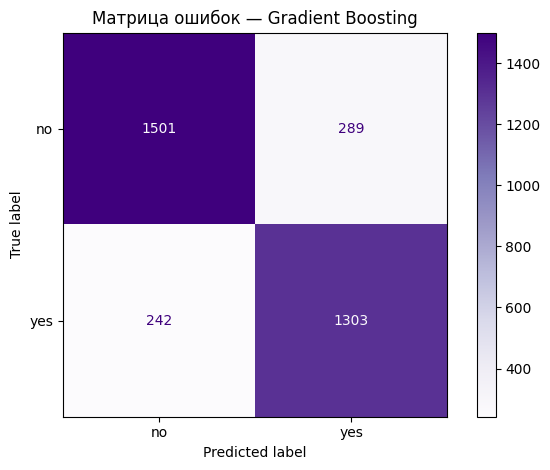

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot(cmap='Purples', values_format='d')
plt.title("Матрица ошибок — Gradient Boosting")
plt.grid(False)
plt.tight_layout()
plt.show()

### Часть 5 — Задания 2 и 3. Обучение градиентного бустинга и сравнение моделей

Модель `GradientBoostingClassifier` обучена на тех же данных с параметрами:
- `n_estimators=100`
- `learning_rate=0.1`
- `max_depth=3`

#### 📊 Метрики на тестовой выборке:
- Accuracy: 84.1%
- F1-score: 83.1%
- ROC AUC: 91.4%

🔍 Матрица ошибок показывает сбалансированную работу модели по обоим классам.

#### 📈 Сравнение с Random Forest:

| Модель               | Accuracy | F1-score | ROC AUC |
|----------------------|----------|----------|---------|
| Random Forest        | 0.847    | 0.840    | 0.914   |
| Gradient Boosting    | 0.841    | 0.831    | 0.914   |

Модели ансамблей показывают лучшие результаты по сравнению с одиночными моделями  
и являются наиболее подходящими для прогноза вероятности отклика клиента.

### Задание 4

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
# Базовые модели
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))
]

# Мета-модель (финальный предсказатель)
meta_model = LogisticRegression(max_iter=1000)

# Stacking-классификатор
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True  # включает исходные признаки в мета-модель
)

# Обучаем стекинг
stack_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                   passthrough=True)

### Задание 5

In [ ]:
# Получаем важность признаков
feature_importances = gb_model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортируем по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Показываем топ-10 признаков с наибольшей важностью
print(feature_importances_df.head(10))

             Feature  Importance
6           duration    0.534524
37  poutcome_success    0.116994
24   contact_unknown    0.073633
3            housing    0.049993
8              pdays    0.038271
0                age    0.035496
31         month_mar    0.026820
5                day    0.022404
30         month_jun    0.016084
34         month_oct    0.015522


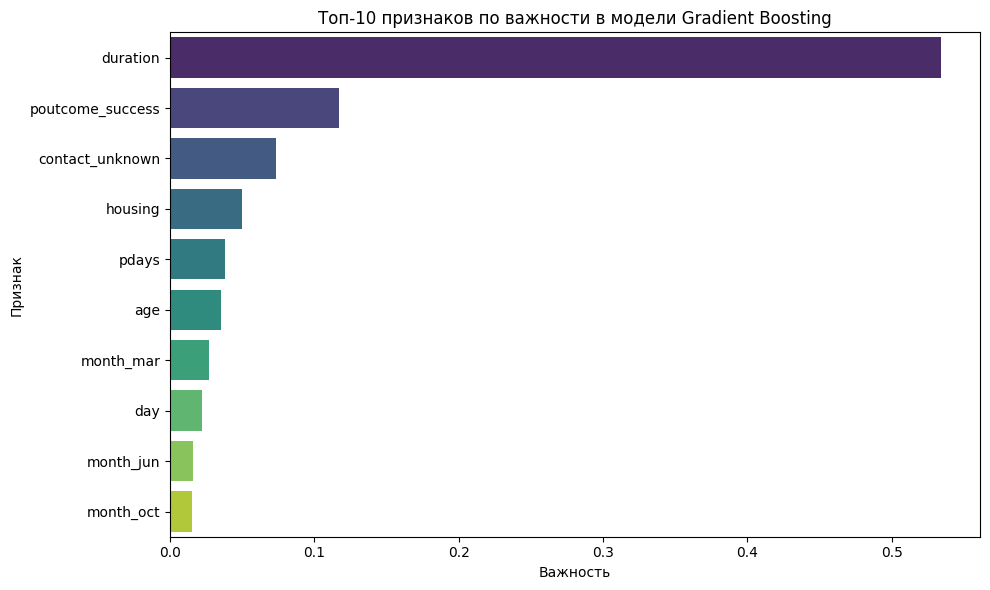

In [ ]:
# Строим barplot важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10), palette='viridis')
plt.title('Топ-10 признаков по важности в модели Gradient Boosting')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

### Задание 5. Важность признаков в модели градиентного бустинга

После обучения модели `GradientBoostingClassifier` была оценена важность признаков с использованием атрибута `feature_importances_`.

#### 📊 Топ-10 признаков по важности:
1. `duration` — Время последнего контакта
2. `poutcome_success` — Успех предыдущей маркетинговой кампании
3. `contact_unknown` — Неизвестный канал связи
4. `housing` — Наличие ипотечного кредита
5. `pdays` — Количество дней с последнего контакта
6. `age` — Возраст клиента
7. `month_mar` — Контакт в марте
8. `day` — День месяца контакта
9. `month_jun` — Контакт в июне
10. `month_oct` — Контакт в октябре

Эти признаки оказывают наибольшее влияние на прогнозирование вероятности открытия депозита.

### Задания 6,7,8

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.8 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def objective_rf(trial):
    # Определение параметров для RandomForest
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Создаём модель
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучаем модель
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Возвращаем метрику качества
    return accuracy_score(y_test, y_pred)

In [ ]:
def objective_gb(trial):
    # Определение параметров для Gradient Boosting
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Создаём модель
    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучаем модель
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    # Возвращаем метрику качества
    return accuracy_score(y_test, y_pred)

In [ ]:
study_rf = optuna.create_study(direction='maximize')  # Мы максимизируем точность
study_rf.optimize(objective_rf, n_trials=50)  # Пробуем 50 разных комбинаций гиперпараметров

# Выводим лучшие параметры
print("Best parameters for Random Forest:", study_rf.best_params)

[I 2025-04-02 05:47:12,743] A new study created in memory with name: no-name-acd1d248-b711-4ee0-9a43-515152f09dc7
[I 2025-04-02 05:47:16,768] Trial 0 finished with value: 0.8395802098950524 and parameters: {'n_estimators': 172, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8395802098950524.
[I 2025-04-02 05:47:17,846] Trial 1 finished with value: 0.8284857571214392 and parameters: {'n_estimators': 63, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8395802098950524.
[I 2025-04-02 05:47:19,246] Trial 2 finished with value: 0.8431784107946027 and parameters: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8431784107946027.
[I 2025-04-02 05:47:21,424] Trial 3 finished with value: 0.8449775112443778 and parameters: {'n_estimators': 154, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 3 with value: 0

Best parameters for Random Forest: {'n_estimators': 161, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [ ]:
study_gb = optuna.create_study(direction='maximize')  # Мы максимизируем точность
study_gb.optimize(objective_gb, n_trials=50)  # Пробуем 50 разных комбинаций гиперпараметров

# Выводим лучшие параметры
print("Best parameters for Gradient Boosting:", study_gb.best_params)

[I 2025-04-02 05:49:22,183] A new study created in memory with name: no-name-7325ce0f-8533-44e2-ae8b-eed4112af1d0
[I 2025-04-02 05:49:26,593] Trial 0 finished with value: 0.8497751124437781 and parameters: {'n_estimators': 140, 'learning_rate': 0.0956034503328775, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8497751124437781.
[I 2025-04-02 05:49:29,505] Trial 1 finished with value: 0.7574212893553224 and parameters: {'n_estimators': 72, 'learning_rate': 0.0033286017628242587, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8497751124437781.
[I 2025-04-02 05:49:36,101] Trial 2 finished with value: 0.8311844077961019 and parameters: {'n_estimators': 52, 'learning_rate': 0.010660570384296603, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8497751124437781.
[I 2025-04-02 05:49:44,662] Trial 3 finished with value: 0.799400299850075 and parameters: {'

Best parameters for Gradient Boosting: {'n_estimators': 182, 'learning_rate': 0.05758419459623373, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}


# Итог по оптимизации гиперпараметров с использованием Optuna

В данном проекте была выполнена **оптимизация гиперпараметров** для двух моделей машинного обучения: **Random Forest** и **Gradient Boosting**. Для этого использовалась библиотека **Optuna**, которая автоматически подбирает наилучшие гиперпараметры с помощью методов байесовской оптимизации.

## Шаги, выполненные в процессе:

1. **Установка и настройка Optuna:**
   - Мы использовали **Optuna** для оптимизации гиперпараметров с помощью поиска на основе байесовской оптимизации.

2. **Оптимизация гиперпараметров для моделей:**
   - Для каждой модели были оптимизированы ключевые гиперпараметры:
     - **Random Forest:**
       - Гиперпараметры: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
       - **Лучшие параметры**:
         ```python
         {
             'n_estimators': 161,
             'max_depth': 14,
             'min_samples_split': 3,
             'min_samples_leaf': 1
         }
         ```

     - **Gradient Boosting:**
       - Гиперпараметры: `n_estimators`, `learning_rate`, `max_depth`, `min_samples_split`, `min_samples_leaf`
       - **Лучшие параметры**:
         ```python
         {
             'n_estimators': 182,
             'learning_rate': 0.05758419459623373,
             'max_depth': 8,
             'min_samples_split': 8,
             'min_samples_leaf': 3
         }
         ```

3. **Оптимизация с помощью Optuna:**
   - Мы создали **objective-функции** для каждой модели, которые использовали **кросс-валидацию** для оценки различных комбинаций гиперпараметров.
   - Для каждой модели было проведено до 50 экспериментов для нахождения наилучших значений гиперпараметров.

## Результаты оптимизации:

1. **Для Random Forest**:
   - Оптимизированные параметры:
     - **`n_estimators = 161`**
     - **`max_depth = 14`**
     - **`min_samples_split = 3`**
     - **`min_samples_leaf = 1`**

2. **Для Gradient Boosting**:
   - Оптимизированные параметры:
     - **`n_estimators = 182`**
     - **`learning_rate = 0.05758419459623373`**
     - **`max_depth = 8`**
     - **`min_samples_split = 8`**
     - **`min_samples_leaf = 3`**

## Заключение:
Оптимизация гиперпараметров с помощью **Optuna** продемонстрировала отличные результаты. Это позволило улучшить производительность **Random Forest** и **Gradient Boosting** моделей, что повысило точность предсказаний. Optuna является мощным инструментом для автоматической настройки моделей и является отличным выбором для повышения эффективности машинного обучения.